Random Walk is a technique to extract sequences from a graph. We can use these sequences to train a skip-gram model to learn node embeddings.

To obtain node embeddings, we first need to arrange for sequences of nodes from the graph. 

How do we get these sequences from a graph? Well, there is a technique for this task called Random Walk.

After generating node-sequences, we have to feed them to a skip-gram model to get node embeddings. That entire process is known as DeepWalk.

You can get the dataset from https://densitydesign.github.io/strumentalia-seealsology/

Steps to download:

a) Enter the following links:

https://en.wikipedia.org/wiki/Space_research

https://en.wikipedia.org/wiki/Space_Race

https://en.wikipedia.org/wiki/Space_exploration

b) Download the TSV file.

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

In [2]:
# Both source and target contain Wikipedia entities. 
# For any row, the entity, in target, has its hyperlink in the Wikipedia page of the entity in the source column.
df = pd.read_csv("space_data.tsv", sep = "\t")
df.head()

,source,target,depth
0,space exploration,discovery and exploration of the solar system,1
1,space exploration,in-space propulsion technologies,1
2,space exploration,robotic spacecraft,1
3,space exploration,timeline of planetary exploration,1
4,space exploration,landings on other planets,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3328 entries, 0 to 3327
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   source  3328 non-null   object
 1   target  3328 non-null   object
 2   depth   3328 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 78.1+ KB


In [5]:
# build the graph from the dataframe
G = nx.from_pandas_edgelist(df, "source", "target", edge_attr=True, create_using=nx.Graph())

In [6]:
# number of nodes
len(G)

2088

In [9]:
# display neighbors of a node - only show the first 4
list(G.neighbors('space exploration'))[:4]

['discovery and exploration of the solar system',
 'in-space propulsion technologies',
 'robotic spacecraft',
 'timeline of planetary exploration']

In [12]:
# return random walk of a node, which is a node sequence
def get_randomwalk(node, path_length):
    
    random_walk = [node]
    
    for i in range(path_length-1):
        temp = list(G.neighbors(node))  # get all neighbors of the node
        temp = list(set(temp) - set(random_walk))  # make sure the starting node won't be selected
        if len(temp) == 0:  # it may stop before 10 steps
            break

        random_node = random.choice(temp)  # random choose one neighbor node
        random_walk.append(random_node)  # attach the neighbor node to the walk
        node = random_node  # assign the random node as the current node
        
    return random_walk

In [13]:
# every time the result might be different
get_randomwalk('space exploration', 10)

['space exploration',
 'exploration of mars',
 'timeline of solar system exploration',
 'timeline of space travel by nationality',
 'timeline of the space race',
 'space race',
 'comparison of asian national space programs',
 'asian century',
 "asia's space race",
 'militarization of space']

In [14]:
# get all nodes 
list(G.nodes())[1:10]

['discovery and exploration of the solar system',
 'in-space propulsion technologies',
 'robotic spacecraft',
 'timeline of planetary exploration',
 'landings on other planets',
 'pioneer program',
 'luna program',
 'zond program',
 'venera program']

In [16]:
# get all random walks for all nodes/entire graph
# for each node we get five random walks
all_nodes = list(G.nodes()) # get list of all nodes from the graph

random_walks = []
for n in tqdm(all_nodes):
    for i in range(5):  # get five random walk results for one starting node
        random_walks.append(get_randomwalk(n, 10))  # each walk with 10 nodes

100%|██████████| 2088/2088 [00:00<00:00, 7160.86it/s]


In [18]:
# count of all random walks for the entire graph
# total nodes: 2088, we get 5 random walks from each
# total is 2088 x 5 = 10440
len(random_walks)

10440

In [21]:
# show the first three walks
random_walks[1:3]

[['space exploration',
  'space architecture',
  'in-situ resource utilization',
  'shackleton energy company',
  'space colonization',
  'exploration of mars',
  'timeline of solar system exploration',
  'timeline of discovery of solar system planets and their moons',
  'solar system'],
 ['space exploration',
  'energy development',
  'energy industry liberalization and privatization (thailand)',
  'nuclear power in thailand']]

In [22]:
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings('ignore')

In [23]:
# train skip-gram (word2vec) model
model = Word2Vec(window=4, sg=1, hs=0,
                 negative=10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed=14)

model.build_vocab(random_walks, progress_per=2)

model.train(random_walks, total_examples=model.corpus_count, epochs=20, report_delay=1)

(976662, 1006660)

In [24]:
model.similar_by_word('space tourism')

[('space flight participant', 0.8429018259048462),
 ('astronaut training', 0.7625536918640137),
 ('space adventures', 0.7552694082260132),
 ('micro-g environment', 0.7545735836029053),
 ('reduced-gravity aircraft', 0.7543785572052002),
 ('paragliding', 0.7403179407119751),
 ('rocketship tours', 0.7222610712051392),
 ('space tourism society', 0.718080461025238),
 ('ultralight aviation', 0.7142132520675659),
 ('glider pilot license', 0.7119032740592957)]

In [26]:
terms = ['lunar escape systems','soviet moonshot', 'soyuz 7k-l1', 
         'moon landing','space food', 'food systems on space exploration missions', 
         'meal, ready-to-eat','space law', 'metalaw', 'moon treaty', 
         'legal aspects of computing','astronaut training', 'reduced-gravity aircraft', 
         'space adaptation syndrome', 'micro-g environment']

In [34]:
# each node returns a (1, 100) embedding
model[['space tourism']]
#print(model[['space tourism']].shape)

array([[-0.49097192, -0.33822984,  0.08244473,  0.0481334 , -0.02178863,
         0.46268326, -0.22990486, -0.789395  ,  0.13268805, -0.1830654 ,
        -0.93857276, -0.701671  , -0.45918247, -0.05825095,  0.251782  ,
         0.04404972, -0.0825301 , -0.17479151,  0.83468634,  0.41999403,
         0.392125  , -0.22535619,  0.20065038, -0.15025069,  0.19163056,
         0.11776656, -0.0992338 , -0.60718477, -0.01014619,  0.40851486,
         0.6561566 , -0.10652129,  0.11577462, -0.29919326, -0.15046678,
         0.08266804, -0.56534743, -0.2675005 , -0.35523114, -0.01518859,
         0.43108776, -0.22538476, -0.06966323, -0.12038989,  0.19176245,
        -0.1835013 , -0.21765757, -0.32862172,  0.3648343 ,  0.385255  ,
         0.34557903, -0.1681979 , -0.12482258,  0.13391973,  0.6641358 ,
        -0.19743147,  0.3692429 , -0.75630224, -0.10723785, -0.2676149 ,
         0.04822698, -0.44226718,  0.59065706, -0.1876925 , -0.1285905 ,
        -0.5019893 ,  0.08352001,  0.13675877, -0.3

In [41]:
# each node has 100 features 
# use PCA to get it down to 2 for plotting
print(model[terms].shape)
pca = PCA(n_components=2)
result = pca.fit_transform(model[terms])
print(result.shape)

(15, 100)
(15, 2)


In [42]:
def plot_nodes(word_list):
    X = model[word_list]
    
    # reduce dimensions to 2
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    
    
    plt.figure(figsize=(12,9))
    # create a scatter plot of the projection
    plt.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(word_list):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))
        
    plt.show()

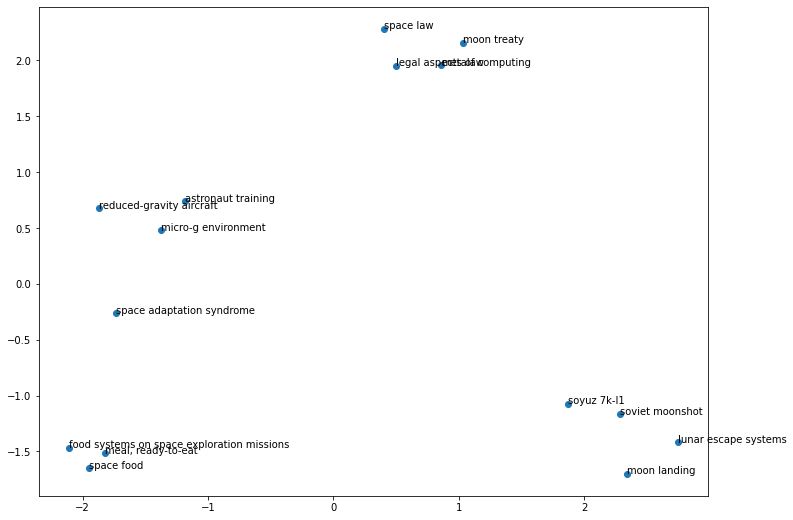

In [43]:
plot_nodes(terms)